In [260]:
#%pip install nbformat
#%pip install imbalanced-learn

In [261]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [262]:
%run ml_project_normalized.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Unique primary colors:
 1. black
 2. non-black
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
Unique primary colors:
 1. black
 2. non-black
cleaned color
cleaned breed
dropped columns


/tmp/ipykernel_992392/1199118304.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
Unique primary colors:
 1. black
 2. non-black
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [263]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import numpy as np
import pandas as pd

def train_XG_classifier(X_train, y_train, X_test, rare_classes, cat_cols, custom_thresholds=None):
    """
    Trains an XGBoost model using hyperparameter tuning.
    Applies custom thresholding during prediction if specified and compares standard vs. custom accuracy.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series or np.array): Training target values.
        X_test (pd.DataFrame): Test features.
        rare_classes (list): List of integer-encoded classes to be oversampled.
        cat_cols (set or list): Categorical columns to one-hot encode.
        custom_thresholds (dict, optional): Dict of class_label -> threshold.
            e.g., {0: 0.7, 1: 0.5, 2: 0.5} for class 0 = supermajority.

    Returns:
        best_estimator: Trained pipeline.
        test_predictions: Custom-thresholded predictions.
        df_importances: Feature importances from XGBoost.
    """
    class_labels = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
    class_weight_dict = dict(zip(class_labels, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])

    categorical_features = [col for col in X_train.columns if col in cat_cols]
    for col in categorical_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("xgb", XGBClassifier(eval_metric='logloss', verbosity=1))
    ])

    param_distributions = {
        "xgb__max_depth": randint(2, 11),
        "xgb__learning_rate": uniform(0.01, 0.29),
        "xgb__n_estimators": randint(50, 501),
        "xgb__subsample": uniform(0.3, 0.7),
        "xgb__colsample_bytree": uniform(0.3, 0.7),
        "xgb__min_child_weight": randint(1, 8),
        "xgb__gamma": uniform(0, 1.0),
        "xgb__reg_alpha": uniform(0, 1.0),
        "xgb__reg_lambda": uniform(0.5, 2.5)
    }

    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=5,
        cv=stratified_cv,
        scoring='balanced_accuracy',
        verbose=3,
        random_state=42,
    )

    print(f"\n[INFO] Starting training with {len(X_train)} samples and {len(y_train)} labels")
    randomized_search.fit(X_train, y_train, **{'xgb__sample_weight': sample_weights})
    print(f"[INFO] Training complete. Best model fitted on {len(X_train)} samples.\n")

    # Show sample transformed training features
    best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
    encoded_X_train = best_preprocessor.transform(X_train)
    if hasattr(encoded_X_train, "toarray"):
        encoded_X_train = encoded_X_train.toarray()
    feature_names = best_preprocessor.get_feature_names_out()
    print("Sample of transformed training features:")
    print(pd.DataFrame(encoded_X_train, columns=feature_names).head())

    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)

    cv_scores = cross_val_score(
        randomized_search.best_estimator_,
        X_train,
        y_train,
        cv=stratified_cv,
        verbose=3,
        scoring='balanced_accuracy'
    )
    print('Generalization accuracy (via cross_val_score):', cv_scores.mean())

    # Predict with custom thresholds if provided
    xgb_model = randomized_search.best_estimator_.named_steps['xgb']
    class_names = xgb_model.classes_

    def apply_custom_thresholds(probabilities, class_names, thresholds_dict):
        thresholds = np.array([thresholds_dict.get(cls, 0.5) for cls in class_names])
        preds = []
        for row in probabilities:
            passed = row >= thresholds
            if not passed.any():
                pred = class_names[np.argmax(row)]
            else:
                pred = class_names[np.argmax(passed * row)]
            preds.append(pred)
        return np.array(preds)

    # Predict on test set
    proba_test = randomized_search.predict_proba(X_test)
    if custom_thresholds:
        print("[INFO] Applying custom threshold logic to test set")
        test_predictions = apply_custom_thresholds(proba_test, class_names, custom_thresholds)
    else:
        test_predictions = randomized_search.predict(X_test)

    # Evaluate performance on training set (standard vs. custom)
    proba_train = randomized_search.predict_proba(X_train)
    if custom_thresholds:
        preds_custom_train = apply_custom_thresholds(proba_train, class_names, custom_thresholds)
        acc_standard = accuracy_score(y_train, randomized_search.predict(X_train))
        acc_custom = accuracy_score(y_train, preds_custom_train)
        bal_acc_standard = balanced_accuracy_score(y_train, randomized_search.predict(X_train))
        bal_acc_custom = balanced_accuracy_score(y_train, preds_custom_train)

        print(f"\nAccuracy Comparison on Training Set:")
        print(f"Standard Accuracy: {acc_standard:.4f}")
        print(f"Custom Threshold Accuracy: {acc_custom:.4f}")
        print(f"Standard Balanced Accuracy: {bal_acc_standard:.4f}")
        print(f"Custom Threshold Balanced Accuracy: {bal_acc_custom:.4f}")

    # Feature importances
    importances = xgb_model.feature_importances_
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    return randomized_search.best_estimator_, test_predictions, df_importances


In [264]:
# from sklearn.utils import resample
# df_train_downsample = resample(df_train, replace=True, n_samples=10000, random_state=42)
# print(df_train_downsample.shape)
'''
X_train = df_train.copy()
print(X_train['breed'].unique())
X_train = bucket_seasons(X_train)
X_train = bucket_days(X_train)
X_train = X_train.drop(columns=['intake_month', 'intake_hour'])
label_column = X_train.pop('outcome_type')
X_train.insert(X_train.shape[1], 'outcome_type', label_column)   
'''

"\nX_train = df_train.copy()\nprint(X_train['breed'].unique())\nX_train = bucket_seasons(X_train)\nX_train = bucket_days(X_train)\nX_train = X_train.drop(columns=['intake_month', 'intake_hour'])\nlabel_column = X_train.pop('outcome_type')\nX_train.insert(X_train.shape[1], 'outcome_type', label_column)   \n"

In [265]:
df_train = bucket_seasons(df_train)
df_test = bucket_seasons(df_test)

df_train = bucket_days(df_train)
df_test = bucket_days(df_test)

df_train['breed'] = df_train['breed'].astype(str)
df_test['breed'] = df_test['breed'].astype(str)

df_train = df_train.drop(columns=['size', 'intake_hour', 'intake_month'])
df_test = df_test.drop(columns=['size', 'intake_hour', 'intake_month'])


In [266]:
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,primary_color,is_mix,good_for_novice_owners,tolerates_being_alone,kid-friendly,easy_to_groom,general_health,energy_level,exercise_needs,potential_for_playfulness,outcome_type,season,time_of_day
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,non-black,0,3,1,5.0,2.0,3.0,5.0,5.0,5.0,Return to Owner,Summer,Afternoon
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,non-black,1,4,4,5.0,5.0,2.0,5.0,5.0,2.0,Return to Owner,Spring,Evening
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,non-black,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Transfer,Spring,Night
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,non-black,1,3,2,5.0,5.0,3.0,5.0,5.0,5.0,Return to Owner,Winter,Afternoon
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,black,1,1,1,5.0,5.0,4.0,5.0,5.0,5.0,Return to Owner,Spring,Morning


In [267]:
df_dog = df_train[df_train['animal_type'] == 'Dog']
df_dog = df_dog[~df_dog['breed'].str.contains('Unknown')]
df_dog = df_dog[~df_dog['breed'].str.contains('Rare')]

df_dog['kid-friendly'] = df_dog['kid-friendly'].astype(int)
df_dog['easy_to_groom'] = df_dog['easy_to_groom'].astype(int)
df_dog['general_health'] = df_dog['general_health'].astype(int)
df_dog['energy_level'] = df_dog['energy_level'].astype(int)
df_dog['exercise_needs'] = df_dog['exercise_needs'].astype(int)
df_dog['potential_for_playfulness'] = df_dog['potential_for_playfulness'].astype(int)

df_dog['potential_for_playfulness'].value_counts()

potential_for_playfulness
5    41957
4    16012
3     1736
2     1150
1      471
Name: count, dtype: int64

In [268]:
print(df_dog.head())

       intake_type   intake_condition animal_type sex_upon_intake  \
0            Stray  Normal / Behavior         Dog   Spayed Female   
1            Stray  Normal / Behavior         Dog     Intact Male   
3  Owner Surrender  Normal / Behavior         Dog   Neutered Male   
4    Public Assist  Normal / Behavior         Dog   Neutered Male   
6    Public Assist  Normal / Behavior         Dog     Intact Male   

   age_upon_intake breed  intake_year primary_color  is_mix  \
0             96.0     2         2015     non-black       0   
1             11.0     7         2016     non-black       1   
3             24.0     2         2017     non-black       1   
4             72.0     3         2019         black       1   
6             24.0     2         2015         black       1   

  good_for_novice_owners tolerates_being_alone  kid-friendly  easy_to_groom  \
0                      3                     1             5              2   
1                      4                     4  

In [269]:
'''
df_train = log_age(df_train)
df_test = log_age(df_test)
df_train.head()

'''

'\ndf_train = log_age(df_train)\ndf_test = log_age(df_test)\ndf_train.head()\n\n'

In [270]:
'''
X_test = df_test.copy()
X_test = bucket_seasons(X_test)
X_test = bucket_days(X_test)
X_test = X_test.drop(columns=['intake_month', 'intake_hour'])
X_test.head()
'''

"\nX_test = df_test.copy()\nX_test = bucket_seasons(X_test)\nX_test = bucket_days(X_test)\nX_test = X_test.drop(columns=['intake_month', 'intake_hour'])\nX_test.head()\n"

In [271]:
cat_cols = ['intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed','season', 'is_mix', 'time_of_day', 'primary_color'] # experimenting with droping color
num_cols = ['log_age', 'intake_year']    # Replace with your actual numerical columns
# freq_cols = ['primary_color'] # for trees

In [272]:
#df_dog = df_dog.drop(columns=[])

In [273]:
X = df_dog.drop(columns=['outcome_type'])
y = df_dog['outcome_type']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)

In [274]:
# Encode the target variable.
le = LabelEncoder()
#y_train = X_train['outcome_type']
#X_train = X_train.drop(columns=['outcome_type'])
y_train = le.fit_transform(y_train)
print('Encoding mapping:', le.classes_)

# Identify rare classes that need oversampling.
rare_classes = [
    label for label, count in pd.Series(y_train).value_counts().items()
    if count < 0.05 * len(y_train)
]
print("Rare classes:")
for cls in rare_classes:
    print(f"  {cls}: {le.classes_[cls]}")

# Define column groups (this example will one-hot encode all columns, so cat_cols and num_cols are not used in the transformer).
cat_cols = {'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'intake_month', 'intake_hour', 'intake_year', 'season', 'time_of_day'}
categorical_features = [col for col in X_train.columns if col in cat_cols]
'''
cat_cols_freq = ['primary_color']

# Frequency encode selected high-cardinality features
for col in cat_cols_freq:
  freq_map = X_train[col].value_counts()
  X_train[col] = X_train[col].map(freq_map)
  X_test[col]  = X_test[col].map(freq_map).fillna(0)
'''
# Train the classifier with the refactored pipeline.

custom_thresholds = {
    0: 0.8,
    1: 0.5,
    2: 0.5,
    3: 0.5,
    4: 0.5
}
best_model, test_predictions, df_importances = train_XG_classifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    rare_classes=rare_classes,
    cat_cols=categorical_features,
    custom_thresholds=custom_thresholds
)

# Convert predictions back to original labels.
predictions = le.inverse_transform(test_predictions)

classification_report_with_accuracy_score(y_test, predictions)
# Save predictions; assumes save_predictions is defined elsewhere.
#save_predictions(predictions, 'xg_boost')

Encoding mapping: ['Adoption' 'Died' 'Euthanasia' 'Return to Owner' 'Transfer']
Rare classes:
  2: Euthanasia
  1: Died

[INFO] Starting training with 49060 samples and 49060 labels
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.22227824312530747, xgb__max_depth=6, xgb__min_child_weight=7, xgb__n_estimators=171, xgb__reg_alpha=0.15599452033620265, xgb__reg_lambda=0.6452090304204987, xgb__subsample=0.9063233020424546;, score=nan total time=   0.1s
[CV 2/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.22227824312530747, xgb__max_depth=6, xgb__min_child_weight=7, xgb__n_estimators=171, xgb__reg_alpha=0.15599452033620265, xgb__reg_lambda=0.6452090304204987, xgb__subsample=0.9063233020424546;, score=nan total time=   0.1s
[CV 3/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 738, in inner_f
    return func(**kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 1580, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 603, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 1065, in _create_dmatrix
    return QuantileDMatrix(
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 738, in inner_f
    return func(**kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 1585, in __init__
    self._init(
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 1644, in _init
    it.reraise()
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 581, in reraise
    raise exc  # pylint: disable=raising-bad-type
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 562, in _handle_exception
    return fn()
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 649, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/data.py", line 1402, in next
    input_data(**self.kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 738, in inner_f
    return func(**kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/core.py", line 629, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/data.py", line 1429, in _proxy_transform
    data, _ = _ensure_np_dtype(data, data.dtype)
  File "/u/nneoma/.local/lib/python3.8/site-packages/xgboost/data.py", line 224, in _ensure_np_dtype
    data = data.astype(dtype, copy=False)
ValueError: could not convert string to float: 'non-black'


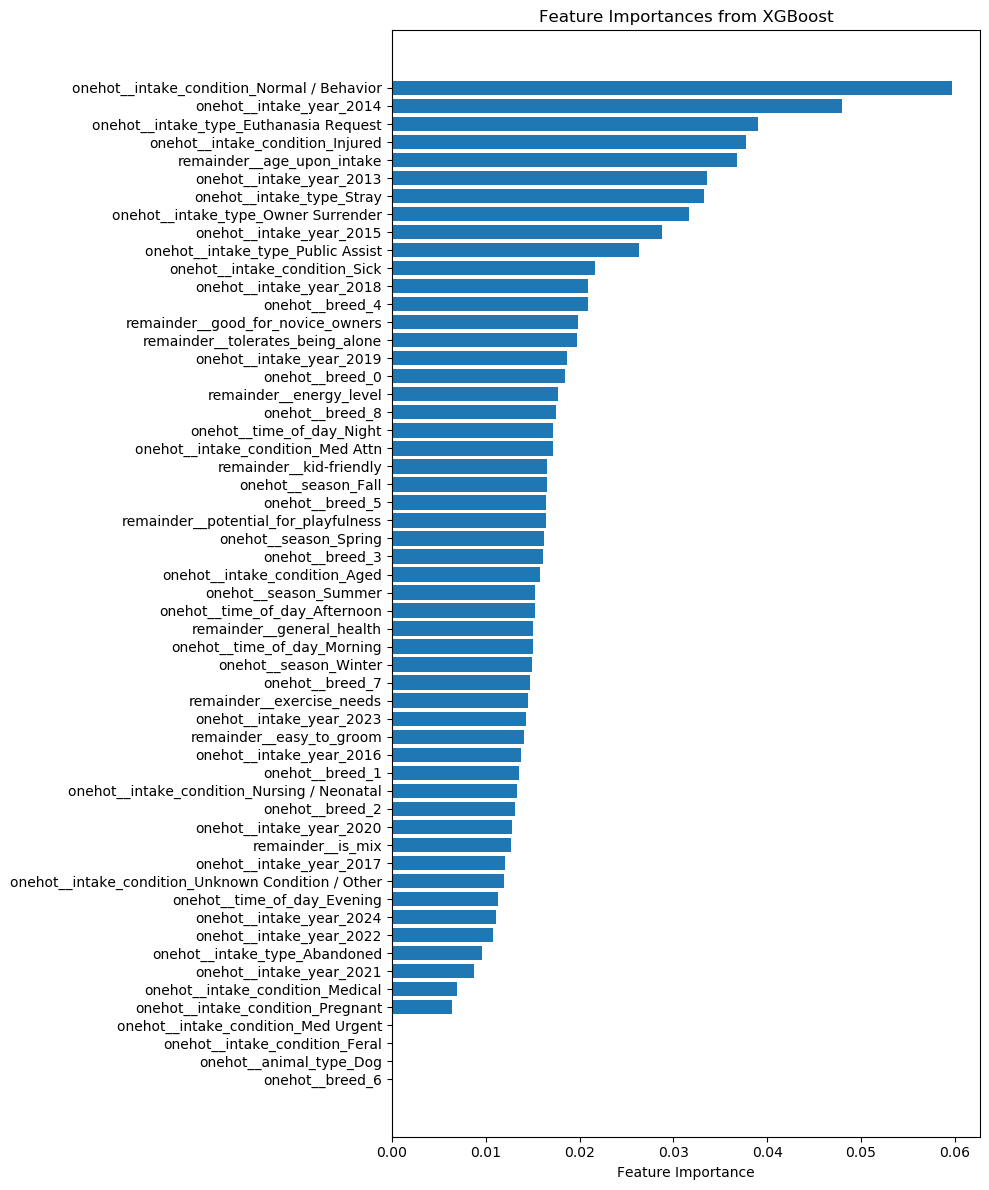

In [ ]:
import matplotlib.pyplot as plt

df_plot = df_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from XGBoost')
plt.tight_layout()
plt.show()